In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import uniform
import matplotlib.pyplot as plt


2024-05-21 23:41:06.032562: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Clear previous TensorFlow session
import tensorflow.keras.backend as K
K.clear_session()



In [3]:
import scipy.io
# Load the .mat file
file_path = '../EV_Rank_1_52_RBs_50_UEs_1000_snaps.mat'
data = scipy.io.loadmat(file_path)

# Extract the relevant data
EV_data = data['EV_re_im_split']

# Check the shape and structure of the extracted data
data = EV_data
del EV_data
data.shape

(50, 1000, 832)

In [4]:
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(data.shape[0]):
        for j in range(data.shape[1] - n_steps_in - n_steps_out + 1):
            X.append(data[i, j:j+n_steps_in, :])
            y.append(data[i, j+n_steps_in:j+n_steps_in+n_steps_out, :])
    return np.array(X), np.array(y)


In [5]:
n_steps_in = 5
n_steps_out = 1

X, y = create_sequences(data, n_steps_in, n_steps_out)
y = y.reshape((y.shape[0], y.shape[2]))  # Flatten the y array

# Ensure data is float32
X = X.astype('float32')
y = y.astype('float32')

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Use a smaller subset of the data for hyperparameter tuning to reduce memory usage
X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)


In [6]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV


# Define the LSTM model with dropout and cuDNN compatible settings
def create_model(optimizer='adam', dropout_rate=0.2, lstm_units=256, dense_units=128):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(n_steps_in, X.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y.shape[1]))  # Output layer
    model.compile(optimizer=optimizer, loss='mse')
    return model


# Create the KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)


/home/rithvik/anaconda3/envs/csi/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [7]:
# Simplified parameter grid for Randomized Search
param_distributions = {
    'batch_size': [16, 32],
    'epochs': [50],
    'optimizer': ['adam'],
    'dropout_rate': [0.2],
    'lstm_units': [128],
    'dense_units': [64]
}



# Create Randomized Search with reduced parameters and sequential execution
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=5, n_jobs=1, cv=3, random_state=42)

# Fit Randomized Search on a subset of the data
random_search_result = random_search.fit(X_train_sub, y_train_sub)

# Print the best parameters
print(f'Best: {random_search_result.best_score_} using {random_search_result.best_params_}')


/home/rithvik/anaconda3/envs/csi/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Best: -0.01009426141778628 using {'optimizer': 'adam', 'lstm_units': 128, 'epochs': 50, 'dropout_rate': 0.2, 'dense_units': 64, 'batch_size': 16}


In [8]:
# Get the best model and evaluate it
best_params = random_search_result.best_params_

# Create the model with the best parameters
best_model = create_model(
    optimizer=best_params['optimizer'],
    dropout_rate=best_params['dropout_rate'],
    lstm_units=best_params['lstm_units'],
    dense_units=best_params['dense_units']
)



In [10]:
# Fit the model on the full training data
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_val, y_val), verbose=1)

# Evaluate the model
y_pred = best_model.predict(X_test)


Epoch 1/50
2177/2177 [==============================] - 18s 7ms/step - loss: 0.0120 - val_loss: 0.0105
Epoch 2/50
2177/2177 [==============================] - 15s 7ms/step - loss: 0.0111 - val_loss: 0.0102
Epoch 3/50
2177/2177 [==============================] - 15s 7ms/step - loss: 0.0110 - val_loss: 0.0101
Epoch 4/50
2177/2177 [==============================] - 15s 7ms/step - loss: 0.0109 - val_loss: 0.0100
Epoch 5/50
2177/2177 [==============================] - 15s 7ms/step - loss: 0.0108 - val_loss: 0.0100
Epoch 6/50
2177/2177 [==============================] - 15s 7ms/step - loss: 0.0108 - val_loss: 0.0099
Epoch 7/50
2177/2177 [==============================] - 14s 6ms/step - loss: 0.0108 - val_loss: 0.0100
Epoch 8/50
2177/2177 [==============================] - 15s 7ms/step - loss: 0.0107 - val_loss: 0.0099
Epoch 9/50
2177/2177 [==============================] - 15s 7ms/step - loss: 0.0107 - val_loss: 0.0099
Epoch 10/50
2177/2177 [==============================] - 15s 7ms/step - l

In [11]:
# Calculate and print metrics
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error: {mape}%')


Mean Squared Error: 0.009704366326332092
Mean Absolute Error: 0.07629963010549545
R^2 Score: 0.3658559322693202
Root Mean Squared Error: 0.0985107421875
Mean Absolute Percentage Error: 257.7460289001465%


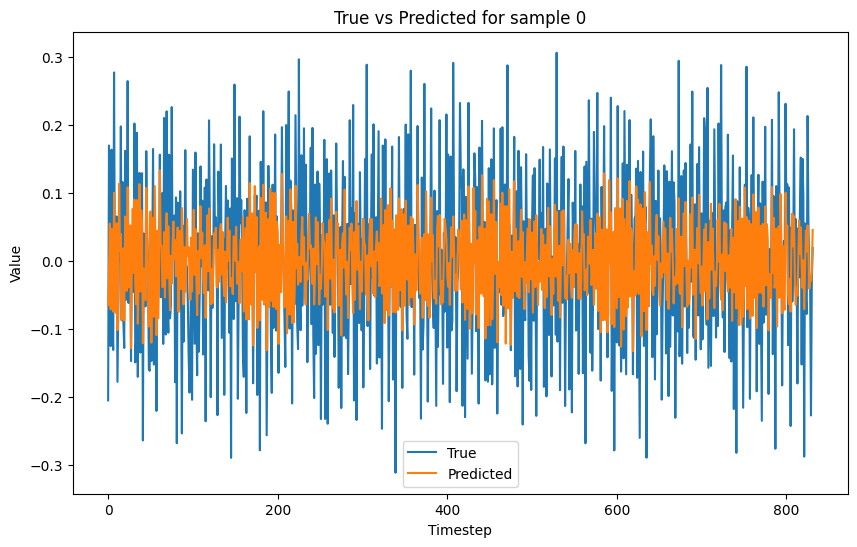

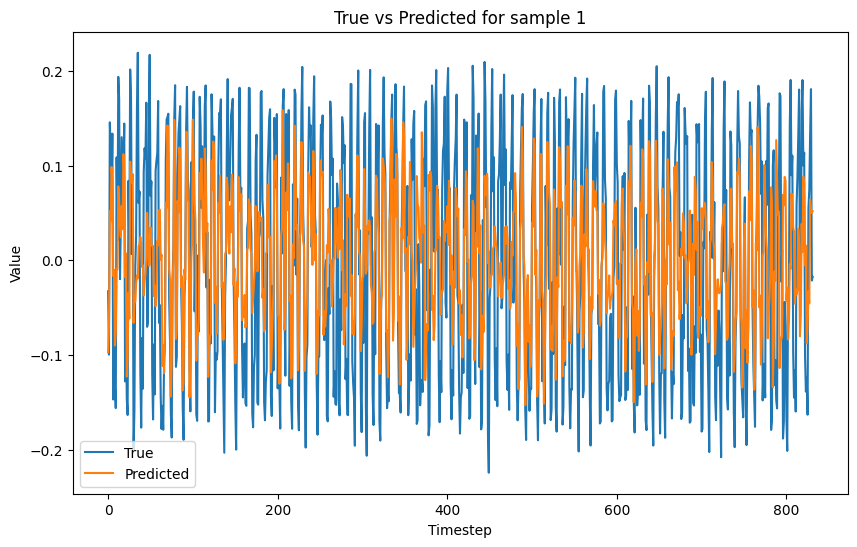

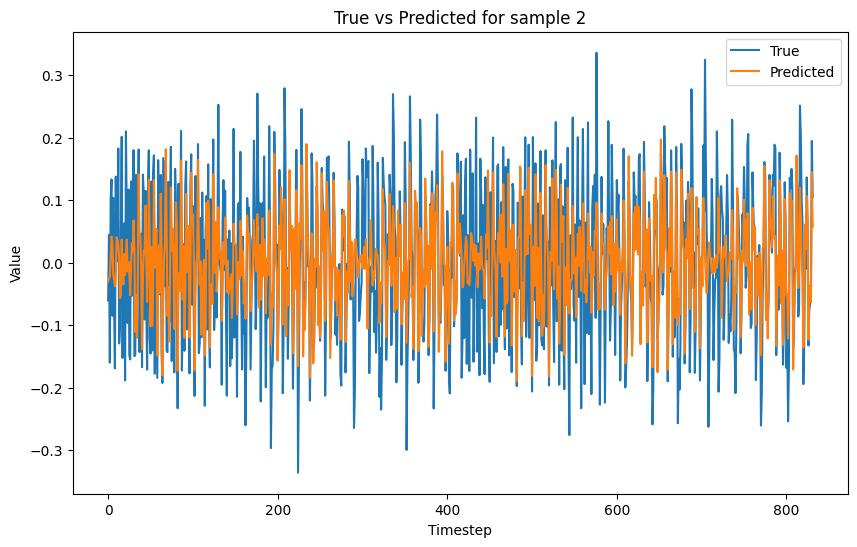

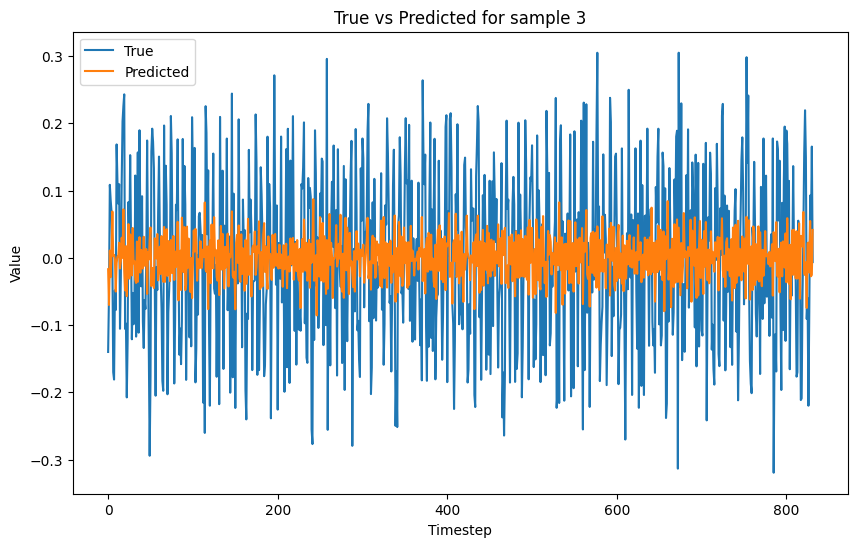

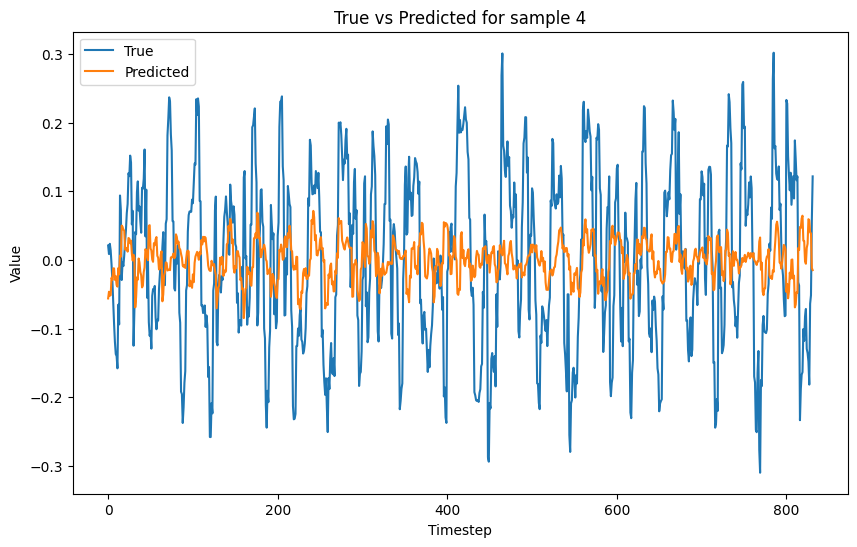

In [12]:
# Visualize Predictions for Different UEs
for sample_index in range(5):  # Change range to visualize different samples
    plt.figure(figsize=(10, 6))
    plt.plot(y_test[sample_index], label='True')
    plt.plot(y_pred[sample_index], label='Predicted')
    plt.title(f'True vs Predicted for sample {sample_index}')
    plt.xlabel('Timestep')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
